# River Tree

An example workflow for gathering NHD Plus data and generating a tree.  This tree can then be iterated over to accumulate data.  Braided systems are merged into a single reach, and the system is simplified relative to NHD Plus's raw format.

This type of workflow is useful for setting up stream network models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import watershed_workflow
import watershed_workflow.crs
import watershed_workflow.sources
import watershed_workflow.config
import watershed_workflow.ui
import watershed_workflow.utils

watershed_workflow.ui.setup_logging(1,None)
crs = watershed_workflow.crs.default_crs


In [3]:
# open a shapefile for use here
shpfile = watershed_workflow.sources.ManagerShapefile(os.path.join('Coweeta', 'input_data', 'coweeta_basin.shp'))
shp = shpfile.getShapes(out_crs=crs)
shp

,AREA,PERIMETER,CWTBASINNA,CWTBASIN_1,BASIN_CODE,SPOT,LABEL,geometry,ID,name
0,1.626020e+07,17521.768,2,1,1,-9999,Coweeta Hydrologic Lab,"POLYGON ((1130750.667 1409230.854, 1130791.743...",0,0


In [4]:
# find the rivers in this shape
nhdv21 = watershed_workflow.sources.hydrography_sources['NHDPlus MR v2.1']
reaches = nhdv21.getShapesByGeometry(shp.geometry.iloc[0], shp.crs, out_crs=crs)
reaches


,geometry,comid,fdate,resolution,gnis_id,reachcode,flowdir,wbareacomi,ftype,fcode,...,ID,name,length,stream_order,drainage_area_sqkm,catchment,hydroseq,uphydroseq,dnhydroseq,divergence
0,"LINESTRING (1132445.584 1408537.306, 1132472.0...",19736291,1999-09-07T04:00:00Z,Medium,1015479,06010202000369,With Digitized,0,StreamRiver,46006,...,19736291,Shope Fork,1.522,2,8.4654,"POLYGON ((1132694.981 1408095.022, 1132714.937...",470029694.0,470041462.0,470024291.0,0
1,"LINESTRING (1133712.415 1408561.857, 1133801.7...",19736305,1999-09-07T04:00:00Z,Medium,1010529,06010202000091,With Digitized,0,StreamRiver,46006,...,19736305,Coweeta Creek,2.771,3,18.7353,"POLYGON ((1134435.01 1407975.003, 1134388.087 ...",470024291.0,470029691.0,470021073.0,0
2,"LINESTRING (1133252.709 1407838.903, 1133289.4...",19736307,1999-09-07T04:00:00Z,Medium,1010529,06010202000092,With Digitized,0,StreamRiver,46006,...,19736307,Coweeta Creek,0.897,2,7.3197,"POLYGON ((1133565.006 1406834.978, 1133548.795...",470029691.0,470041447.0,470024291.0,0
3,"LINESTRING (1131251.957 1406995.258, 1131272.8...",19736315,1999-09-07T04:00:00Z,Medium,1010615,06010202000371,With Digitized,0,StreamRiver,46006,...,19736315,Cunningham Creek,2.107,1,1.7109,"POLYGON ((1130565.011 1406685.014, 1130580.495...",470041463.0,0.0,470029694.0,0
4,"LINESTRING (1130537.001 1406775.771, 1130603.9...",19736317,1999-09-07T04:00:00Z,Medium,1015479,06010202000370,With Digitized,0,StreamRiver,46006,...,19736317,Shope Fork,3.062,1,4.8258,"POLYGON ((1130084.983 1406295.04, 1130111.018 ...",470041462.0,0.0,470029694.0,0
5,"LINESTRING (1130687.925 1405227.347, 1130713.3...",19736355,1999-09-07T04:00:00Z,Medium,1010529,06010202000093,With Digitized,0,StreamRiver,46006,...,19736355,Coweeta Creek,4.021,1,2.4777,"POLYGON ((1130175.03 1405394.996, 1130131.202 ...",470041447.0,0.0,470029691.0,0
6,"LINESTRING (1131225.581 1405291.462, 1131279.8...",19736357,2009-03-15T04:00:00Z,Medium,1011984,06010202000372,With Digitized,0,StreamRiver,46006,...,19736357,Henson Creek,3.561,1,3.7737,"POLYGON ((1131375.013 1404734.979, 1131358.121...",470041446.0,0.0,470029691.0,0


In [5]:
# make the global tree
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

# check that only one tree was formed
assert(len(rivers) == 1)
river = rivers[0]

<Axes: >

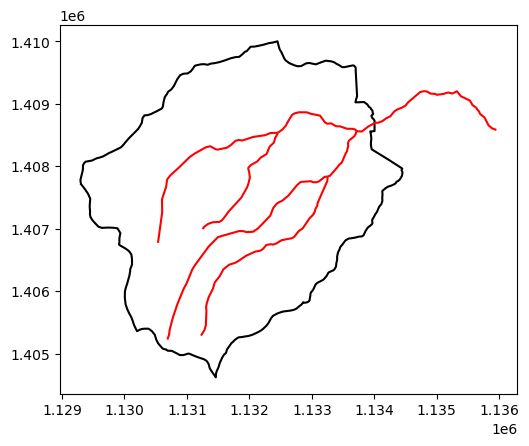

In [6]:
ax = shp.boundary.plot(color='k')
reaches.plot(color='r', ax=ax)


In [7]:
print('NAME: length')
print('-------------')
gnis_name = 'GNIS_Name' if 'GNIS_Name' in river else 'gnis_name'

for r in river:
    print(f"{r.properties['name']}: {r.properties['shape_length']}")

NAME: length
-------------
Coweeta Creek: 0.0288714963622201
Coweeta Creek: 0.00886730048267512
Henson Creek: 0.035737774509713
Coweeta Creek: 0.0408512091814329
Shope Fork: 0.0159618921169526
Cunningham Creek: 0.02117534397197
Shope Fork: 0.0312003700558532
